In [1]:
from IPython.display import HTML
from IPython.display import Image

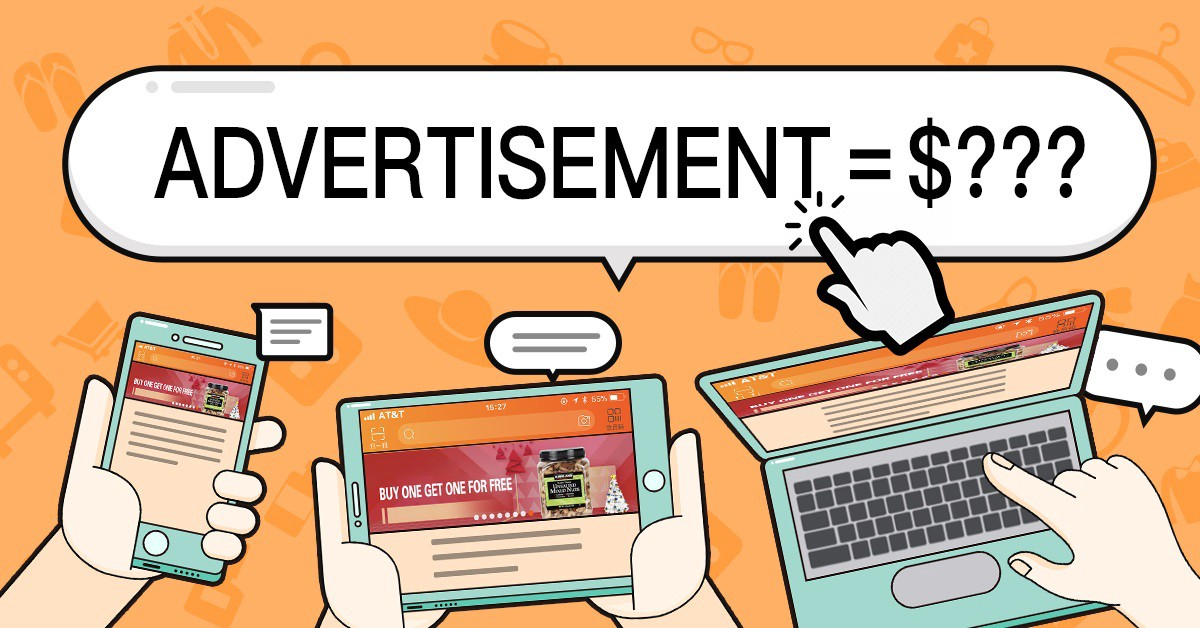

In [2]:
Image("banner.jpeg")

Project: Model Exploration for Click-Through Rate Prediction
======

**By: John Burt and Pieter Leffers**

*Start Date: 06/11/2018*

*Completion Date:*

Project Description
--------

For online advertising, click-through rate (CTR) is an important metric for identifying if an advertisement (*'Creative'*) is being viewed and providing an *'impression'* on the viewer of the advertisement. Presumably with the right kind / frequency of *'impressions'* on the viewer, the viewer will click on the advertisement; causing a *'conversion'*. A *'conversion'* is a moment when a viewer clicks on an advertisement (or some other action) on a provider's web page fulfilling the click objective of the creative. Click-through rate (CTR) is essential for online advertisement agencies and Ad Serving companies and is widely used as a metric for sponsored search options and real-time bidding.

For this project we aren't particularly interested in the Kaggle competition per-se since the competition has already ended. However, starting with a Kaggle dataset should help us get a better picture of the data format as well as the models we would want to implement on data of this kind. Once we have achieved the goal of finding an adequate enough model capable of predicting click-through rate, the next logical step would be searching for a *'real world'* data source of sufficient size and try to implement our final model in a meaningful way.

***Terms used***

**Conversion / Acquisition:** When a user signs up, makes a purchase, or performs some other desired action in response to an ad displayed on the Internet.

**Ad server:** Computer or group of computers responsible for actually serving creatives to websites or for making decisions about what ads will serve. An ad server may also track clicks on ads and other data. 

**Impression:** A creative served to a single user at a single point in time. 


Data Source(s)
-------

The data source we are using for this project is 10 days worth of Avazu data from a Kaggle competition between the dates (11/18/2014 6:04 PM UTC and 2/9/2015 11:59 PM UTC). We have chosen to use this data for exploring models and trying to define and tune parameters for our model building process. 


For more information about the Kaggle competition follow this link:  https://www.kaggle.com/c/avazu-ctr-prediction 


    Avazu: https://www.kaggle.com/c/avazu-ctr-prediction

    Criteo: https://www.kaggle.com/c/criteo-display-ad-challenge

    Outbrain: https://www.kaggle.com/c/outbrain-click-prediction

    RecSys 2015: http://dl.acm.org/citation.cfm?id=2813511&dl=ACM&coll=DL&CFID=941880276&CFTOKEN=60022934

    CriteoLabs 1T Click Data: http://labs.criteo.com/2013/12/download-terabyte-click-logs/

File descriptions

    train - Training set. 10 days of click-through data, ordered chronologically. Non-clicks and clicks are subsampled according to different strategies.
    test - Test set. 1 day of ads to for testing your model predictions. 
    sampleSubmission.csv - Sample submission file in the correct format, corresponds to the All-0.5 Benchmark.

Data fields

    id: ad identifier
    click: 0/1 for non-click/click
    hour: format is YYMMDDHH, so 14091123 means 23:00 on Sept. 11, 2014 UTC.
    C1 -- anonymized categorical variable
    banner_pos
    site_id
    site_domain
    site_category
    app_id
    app_domain
    app_category
    device_id
    device_ip
    device_model
    device_type
    device_conn_type
    C14-C21 -- anonymized categorical variables


In [3]:
HTML('''<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>''')

Import Packages

In [4]:
import pandas as pd
import numpy as np
import random
#import xlearn as xl
#logistic regression l1 regularization
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
# For Visualization
import matplotlib.pyplot as plt
#displays better in jupyter notebooks
%matplotlib inline

In [ ]:
location='C://Users/pmlef/Documents/Python_work/Python_for_Data_Analysis/ClickData/'
data=pd.read_csv(location+'train.csv')
data.head()

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40428967 entries, 0 to 40428966
Data columns (total 24 columns):
id                  float64
click               int64
hour                int64
C1                  int64
banner_pos          int64
site_id             object
site_domain         object
site_category       object
app_id              object
app_domain          object
app_category        object
device_id           object
device_ip           object
device_model        object
device_type         int64
device_conn_type    int64
C14                 int64
C15                 int64
C16                 int64
C17                 int64
C18                 int64
C19                 int64
C20                 int64
C21                 int64
dtypes: float64(1), int64(14), object(9)
memory usage: 7.2+ GB


We can see the full dataset is quite large with 40 million rows and takes up 7.2 gigs of memory and some change. For simply exploring models we should be able to get away with pulling a representative sample of the data. Furthermore we can also see for model building we will need to transform a number of the variables into integers to play nice with scikit-learn and other packages.

In [9]:
#np.asarray(data.values).tofile('data_train.dat')

Simple Random Sampling Method
-------

In [21]:
#This process will take a few minutes!

n = 40428967 #number of rows in the file
s = 500000 #desired sample size

convDict={'site_id':lambda x: int(x,16),
                     'site_domain':lambda x: int(x,16),
                     'site_category':lambda x: int(x,16),
                     'app_id':lambda x: int(x,16),
                     'app_domain':lambda x: int(x,16),
                     'app_category':lambda x: int(x,16),
                     'device_id':lambda x: int(x,16),
                     'device_ip':lambda x: int(x,16),
                     'device_model':lambda x: int(x,16),
                     'device_type':lambda x: int(x,16),
                     'device_conn_type':lambda x: int(x,16),
                    }
skip = sorted(random.sample(range(n),n-s))
#,converters=convDict
location='C://Users/pmlef/Documents/Python_work/Python_for_Data_Analysis/ClickData/'
data=pd.read_csv(location+'train.csv', skiprows=skip, header=None,converters=convDict) #Import only 500,000 randomized rows

DataHeader=pd.read_csv(location+'train.csv', nrows=0) #Grab the header from the Raw Dataset
data.columns=DataHeader.columns #Replace column names with those from the Raw Dataset

In the above step we create a dictionary for modifying the features to integers as well as a convenient method for executing a simple random sample of the data. At the given moment for ease and speed of working with the data we chose to sample 500,000 rows of the 40 million. For representativeness I usually try to stick to a 20% rule; where I will pull a minimum of 20% of the data to describe the rest of the set. For efficiency I am intentionally choosing to ignore this until I have everything in place and working properly. Then I will increase the sample size afterwards on the final pass.

In [22]:
data.head()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,10013222055782902774,0,14102100,1005,0,5b08c53b,7687a86e,3e814130,ecad2386,7801e8d9,...,1,0,17654,300,250,1994,2,39,-1,33
1,10015857277683848936,0,14102100,1005,0,543a539e,c7ca3108,3e814130,ecad2386,7801e8d9,...,1,0,20362,320,50,2333,0,39,-1,157
2,10025633842336165171,0,14102100,1010,1,85f751fd,c4e18dd6,50e219e0,8c0dcd5a,7801e8d9,...,4,0,21665,320,50,2493,3,35,-1,117
3,1003130369744016931,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,2,15708,320,50,1722,0,35,-1,79
4,10039188268655357133,0,14102100,1005,0,f282ab5a,61eb5bc4,f028772b,ecad2386,7801e8d9,...,1,0,20596,320,50,2161,0,35,-1,157


Convert Hex Column Values to Integers: 
    - site_id, site_domain, site_category, app_id, app_domain, app_category, device_id, device_ip, device_model

In [23]:
#Conversion list from Hex to numbers

convList=['site_id',
          'site_domain',
          'site_category',
          'app_id',
          'app_domain',
          'app_category',
          'device_id',
          'device_ip',
          'device_model',
         ]

for i in convList:
    data[i]=data[i].apply(lambda x: int(x,16))
    
data.head()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,10013222055782902774,0,14102100,1005,0,1527301435,1988601966,1048658224,3970769798,2013391065,...,1,0,17654,300,250,1994,2,39,-1,33
1,10015857277683848936,0,14102100,1005,0,1413108638,3351916808,1048658224,3970769798,2013391065,...,1,0,20362,320,50,2333,0,39,-1,157
2,10025633842336165171,0,14102100,1010,1,2247578109,3303116246,1356995040,2349714778,2013391065,...,4,0,21665,320,50,2493,3,35,-1,117
3,1003130369744016931,0,14102100,1005,0,532546046,4085536615,680550077,3970769798,2013391065,...,1,2,15708,320,50,1722,0,35,-1,79
4,10039188268655357133,0,14102100,1005,0,4068649818,1642814404,4029183787,3970769798,2013391065,...,1,0,20596,320,50,2161,0,35,-1,157


In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500001 entries, 0 to 500000
Data columns (total 24 columns):
id                  500001 non-null uint64
click               500001 non-null int64
hour                500001 non-null int64
C1                  500001 non-null int64
banner_pos          500001 non-null int64
site_id             500001 non-null int64
site_domain         500001 non-null int64
site_category       500001 non-null int64
app_id              500001 non-null int64
app_domain          500001 non-null int64
app_category        500001 non-null int64
device_id           500001 non-null int64
device_ip           500001 non-null int64
device_model        500001 non-null int64
device_type         500001 non-null int64
device_conn_type    500001 non-null int64
C14                 500001 non-null int64
C15                 500001 non-null int64
C16                 500001 non-null int64
C17                 500001 non-null int64
C18                 500001 non-null int64
C19   

We can see the sample is working and now all of the features have been coded to integers for the model building steps. 

Counts of unique values in each column:

In [25]:
Counts=pd.DataFrame(index=['Counts'])
for i in data.columns:
    Counts[i]=data[i].unique().shape
Counts.T 

,Counts
id,500001
click,2
hour,240
C1,7
banner_pos,7
site_id,2280
site_domain,2300
site_category,21
app_id,2502
app_domain,172


Above is a cleaner look at the data where we can see unique value counts. This is important because it is showing the difficulty in describing some of the data. Not everything will plot nicely and furthermore we don't know what the C columns are describing so we are capable plotting and exploring only a few featres of the dataset.

Text(0,0.5,'Count of Clicks vs Non-Clicks')

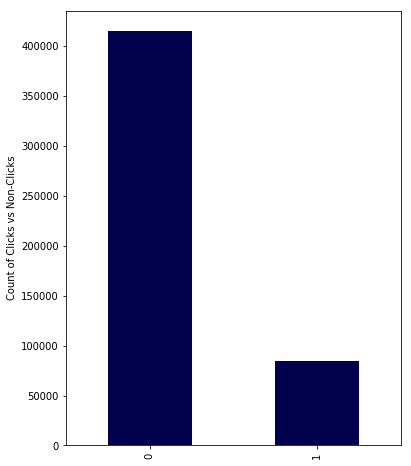

In [26]:
data.click.value_counts().plot(kind='bar',figsize=(6,8),cmap='seismic',legend=False)
plt.ylabel('Count of Clicks vs Non-Clicks')

In [27]:
data.click.value_counts()

0    414998
1     85003
Name: click, dtype: int64

In [28]:
print('The overall click rate from the random sample is',(data.click.value_counts()[1]/data.click.value_counts()[0])*100,'percent.')

The overall click rate from the random sample is 20.482749314454527 percent.


Above we can see the difference in number of clicks vs non-clicks in the dataset. Since we are predicting clicks this is very important in terms of how well we will be able to predict the data. From above we can see that there are approximately 20% of clicks vs non-clicks, which is actually pretty good in my opinion; meaning that we have enough clicks in order to do a prediction and we probably don't need to do any resampling at the moment.

In [29]:
table=data['banner_pos'][data['click']==0].value_counts()
ones=data['banner_pos'][data['click']==1].value_counts()
table=pd.DataFrame(table)
table['Click']=ones
table.rename(index=str,columns={'banner_pos':'NonClick'},inplace=True)
table

,NonClick,Click
0,301000,58963
1,113323,25812
7,375,190
2,139,16
4,83,8
5,60,10
3,18,4


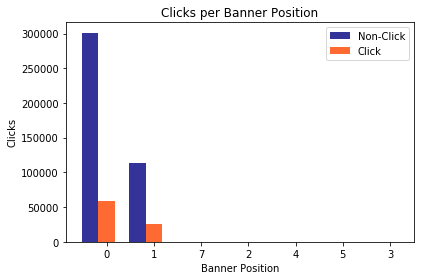

In [30]:
# data to plot
n_groups = 7
counts_zero = np.array(table.NonClick)
counts_ones = np.array(table.Click)
 
# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8
 
rects1 = plt.bar(index, counts_zero, bar_width,
                 alpha=opacity,
                 color='navy',
                 label='Non-Click')
 
rects2 = plt.bar(index + bar_width, counts_ones, bar_width,
                 alpha=opacity,
                 color='orangered',
                 label='Click')
 
plt.xlabel('Banner Position')
plt.ylabel('Clicks')
plt.title('Clicks per Banner Position')
plt.xticks(index + bar_width, (table.index))
plt.legend()
 
plt.tight_layout()
plt.show()

C1

In [31]:
table=data['C1'][data['click']==0].value_counts()
ones=data['C1'][data['click']==1].value_counts()
table=pd.DataFrame(table)
table['Click']=ones
table.rename(index=str,columns={'C1':'NonClick'},inplace=True)
table

,NonClick,Click
1005,381264,77842
1002,21808,5802
1010,10078,1104
1012,1209,221
1007,441,18
1001,137,6
1008,61,10


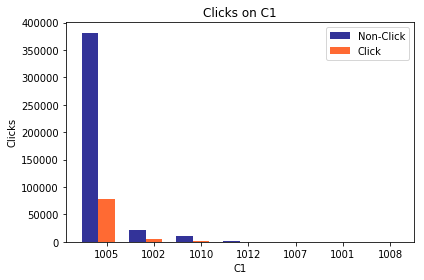

In [32]:
# data to plot
n_groups = 7
counts_zero = np.array(table.NonClick)
counts_ones = np.array(table.Click)
 
# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8
 
rects1 = plt.bar(index, counts_zero, bar_width,
                 alpha=opacity,
                 color='navy',
                 label='Non-Click')
 
rects2 = plt.bar(index + bar_width, counts_ones, bar_width,
                 alpha=opacity,
                 color='orangered',
                 label='Click')
 
plt.xlabel('C1')
plt.ylabel('Clicks')
plt.title('Clicks on C1')
plt.xticks(index + bar_width, (table.index))
plt.legend()
 
plt.tight_layout()
plt.show()

Train/Test Split
===========

In [33]:
def train_validate_test_split(df, train_percent=.6, validate_percent=.2):
    perm = df.index
    m = len(df)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.loc[perm[:train_end]]
    validate = df.loc[perm[train_end:validate_end]]
    test = df.loc[perm[validate_end:]]
    return train, validate, test

In [34]:
train, validate, test = train_validate_test_split(data)

Here we are running a train/test split in order to give us more options for evaluative measures on the models.

Why Logistic Regression?
----

Explanation blah blah blah

Regularized Logistic Regression (Batch Gradient Descent)
-------------------

https://stats.stackexchange.com/questions/89484/how-to-compute-the-standard-errors-of-a-logistic-regressions-coefficients

In [35]:
y=pd.DataFrame(train['click']).copy()

**Outcome**

In [36]:
y.head()

,click
0,0
1,0
2,0
3,0
4,0


**Features**

In [37]:
X=train.iloc[:,1:].copy()
#X=data.iloc[:,1:].copy()
X['click']=1
X.rename(index=str, columns={'click': 'intercept'},inplace=True)

In [38]:
X.head()

,intercept,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,1,14102100,1005,0,1527301435,1988601966,1048658224,3970769798,2013391065,131587874,...,1,0,17654,300,250,1994,2,39,-1,33
1,1,14102100,1005,0,1413108638,3351916808,1048658224,3970769798,2013391065,131587874,...,1,0,20362,320,50,2333,0,39,-1,157
2,1,14102100,1010,1,2247578109,3303116246,1356995040,2349714778,2013391065,253846008,...,4,0,21665,320,50,2493,3,35,-1,117
3,1,14102100,1005,0,532546046,4085536615,680550077,3970769798,2013391065,131587874,...,1,2,15708,320,50,1722,0,35,-1,79
4,1,14102100,1005,0,4068649818,1642814404,4029183787,3970769798,2013391065,131587874,...,1,0,20596,320,50,2161,0,35,-1,157


In [39]:
colNames=list(X.columns)
m,n = X.shape
y = np.array(y)
theta = np.array(np.zeros(n).reshape(n,1))

**Using L2 Regularization**
-----

In [40]:
from sklearn import linear_model

def regLogitRegress(X,y):
    model = linear_model.LogisticRegression(penalty='l2')# Setting Regularization Parameter, penalty='l2', C=.2
    model.fit(X, y.ravel())
    Accuracy=model.score(X, y)
    print('The accuracy of the model (R-Square):',Accuracy)
    coeff_df = pd.DataFrame(data=list(zip(X.columns, model.coef_[0].T)),columns=['Coefficient','Estimate'])
    #coeff_df['Odds']=np.exp(coeff_df['Estimate'])
    Y_mean=y.mean()
    print('Target average:',Y_mean)
    return coeff_df

In [41]:
%%time
Output=regLogitRegress(X,y)

The accuracy of the model (R-Square): 0.8250366666666666
Target average: 0.17496333333333333
Wall time: 18 s


**Estimates**

In [42]:
Output

,Coefficient,Estimate
0,intercept,-7.890672e-15
1,hour,-1.112711e-07
2,C1,-7.960258e-12
3,banner_pos,1.961710e-14
4,site_id,2.142562e-11
5,site_domain,-1.290584e-10
6,site_category,-9.761008e-11
7,app_id,1.859839e-10
8,app_domain,-9.268623e-11
9,app_category,-2.991452e-11


**Using L1 Regularization**
-----

In [ ]:
#from sklearn import linear_model

def regLogitRegress(X,y):
    model = linear_model.LogisticRegression(penalty='l2')# Setting Regularization Parameter, penalty='l2', C=.2
    model.fit(X, y.ravel())
    Accuracy=model.score(X, y)
    print('The accuracy of the model (R-Square):',Accuracy)
    coeff_df = pd.DataFrame(data=list(zip(X.columns, model.coef_[0].T)),columns=['Coefficient','Estimate'])
    #coeff_df['Odds']=np.exp(coeff_df['Estimate'])
    Y_mean=y.mean()
    print('Target average:',Y_mean)
    return coeff_df

In [ ]:
%%time
Output=regLogitRegress(X,y)

**Estimates**

In [ ]:
Output

Regularized Logistic Regression (Stochastic Gradient Descent)
---------------------------

In [43]:
y=pd.DataFrame(train['click']).copy()

**Outcome**

In [44]:
y.head()

,click
0,0
1,0
2,0
3,0
4,0


In [45]:
X=train.iloc[:,1:].copy()
#X=data.iloc[:,1:].copy()
X['click']=1
X.rename(index=str, columns={'click': 'intercept'},inplace=True)

**Features**

In [46]:
X.head()

,intercept,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,1,14102100,1005,0,1527301435,1988601966,1048658224,3970769798,2013391065,131587874,...,1,0,17654,300,250,1994,2,39,-1,33
1,1,14102100,1005,0,1413108638,3351916808,1048658224,3970769798,2013391065,131587874,...,1,0,20362,320,50,2333,0,39,-1,157
2,1,14102100,1010,1,2247578109,3303116246,1356995040,2349714778,2013391065,253846008,...,4,0,21665,320,50,2493,3,35,-1,117
3,1,14102100,1005,0,532546046,4085536615,680550077,3970769798,2013391065,131587874,...,1,2,15708,320,50,1722,0,35,-1,79
4,1,14102100,1005,0,4068649818,1642814404,4029183787,3970769798,2013391065,131587874,...,1,0,20596,320,50,2161,0,35,-1,157


In [47]:
colNames=list(X.columns)
m,n = X.shape
y = np.array(y)
theta = np.array(np.zeros(n).reshape(n,1))

In [48]:
from sklearn import linear_model

def sgdLogitRegress(X,y):
    # model = linear_model.LogisticRegression(penalty='l1', C=1.0, verbose=True)
    model = linear_model.SGDClassifier(loss='log',penalty='l2',max_iter=25, tol=None, verbose=False,alpha=.01)
    model.fit(X, y.ravel())
    Accuracy=model.score(X, y)
    print('The accuracy of the model (R-Square):',Accuracy)
    coeff_df = pd.DataFrame(data=list(zip(X.columns, model.coef_[0].T)),columns=['Coefficient','Estimate'])
    Y_mean=y.mean()
    print('Target average:',Y_mean)
    return coeff_df

In [49]:
%%time
Output=sgdLogitRegress(X,y)

The accuracy of the model (R-Square): 0.81883
Target average: 0.17496333333333333
Wall time: 5.12 s


In [50]:
Output

,Coefficient,Estimate
0,intercept,-0.057606
1,hour,-812287.726886
2,C1,-58.413741
3,banner_pos,0.315612
4,site_id,-40327.174649
5,site_domain,-69428.681447
6,site_category,-51387.165524
7,app_id,63494.532149
8,app_domain,-55912.651180
9,app_category,-58194.673776


Regression Trees (Random Forest)
-----------------

In [51]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt

**Outcome**

In [52]:
y=pd.DataFrame(train['click']).copy()
y_colNames=y.columns
y.head()

,click
0,0
1,0
2,0
3,0
4,0


**Features**

In [53]:
X=train.iloc[:,1:].copy()
X['click']=1
X.rename(index=str, columns={'click': 'intercept'},inplace=True)
X_colNames=X.columns

In [54]:
colNames=list(X.columns)
m,n = X.shape
y = np.array(y)
theta = np.array(np.zeros(n).reshape(n,1))

In [55]:
X.head()

,intercept,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,1,14102100,1005,0,1527301435,1988601966,1048658224,3970769798,2013391065,131587874,...,1,0,17654,300,250,1994,2,39,-1,33
1,1,14102100,1005,0,1413108638,3351916808,1048658224,3970769798,2013391065,131587874,...,1,0,20362,320,50,2333,0,39,-1,157
2,1,14102100,1010,1,2247578109,3303116246,1356995040,2349714778,2013391065,253846008,...,4,0,21665,320,50,2493,3,35,-1,117
3,1,14102100,1005,0,532546046,4085536615,680550077,3970769798,2013391065,131587874,...,1,2,15708,320,50,1722,0,35,-1,79
4,1,14102100,1005,0,4068649818,1642814404,4029183787,3970769798,2013391065,131587874,...,1,0,20596,320,50,2161,0,35,-1,157


In [56]:
model = RandomForestClassifier(n_estimators=15,random_state=0,max_features="auto") #(sqrt n features)="auto"
model.fit(X, y.ravel())
Accuracy=model.score(X, y)
print(Accuracy)

0.9890366666666667


In [59]:
importFeature=model.feature_importances_ 
output=pd.DataFrame(importFeature,columns=['Feature Importance'])
output['Features']=colNames
output.sort_values(by='Feature Importance',ascending=False)

,Feature Importance,Features
11,0.287825,device_ip
1,0.208569,hour
12,0.184509,device_model
15,0.066446,C14
21,0.039188,C20
10,0.034207,device_id
4,0.030695,site_id
5,0.027572,site_domain
22,0.019220,C21
18,0.017377,C17


Decision Trees with Adaboost
===========

Equalize number of click vs non-click samples for training
----------

In [60]:
# extract our X and y variables for training
y = train['click'].copy()
X = train[train.columns.values[2:]].copy()

# from the larger dataset, subsample nsamps click and no-click records
y0 = y[y==0]
X0 = X[y==0]
y1 = y[y==1]
X1 = X[y==1]

# nsamps = y1.shape[0] # use as many samples as possible
nsamps = 500000

print("original data = %d rows: %d clicks, %d nonclicks %1.1f%% clicks"%(
    y.shape[0], y1.shape[0], y0.shape[0], 100*y1.shape[0]/y.shape[0]))

y_eq = y1[:nsamps].append(y0[:nsamps], ignore_index=True)
X_eq = X1[:nsamps].append(X0[:nsamps], ignore_index=True)

print("training data = %d rows, equal# clicks/nonclicks "%(y_eq.shape[0]))

original data = 300000 rows: 52489 clicks, 247511 nonclicks 17.5% clicks
training data = 300000 rows, equal# clicks/nonclicks 




original data = 500000 rows: 82037 clicks, 417963 nonclicks 16.4% clicks training data = 164074 rows, equal# clicks/nonclicks


In [61]:
from time import time
from scipy import stats
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

rng = np.random.RandomState(1)

# Define SGDClassifier defaults: 
# define defaults: doing it this way allows us to define our own default params
clf_defaults = {
    'base_estimator' : DecisionTreeClassifier(max_depth=4),
    'n_estimators' : 100, 
    'learning_rate' : 1,
    }

# Create a pipeline, allowing to tune a transformer and the SGDClassifier classifier.
# (transformer not implemented yet)
pipeline = Pipeline([   
    ('clf', AdaBoostClassifier(**clf_defaults, random_state=rng))
])

# Define the parameters and values we want to test.
# Uncommenting more parameters will give better exploring power but will
#   increase processing time in a combinatorial way. I suggest tuning <= 3
#   parameters at a time.
# Note the naming format: pipelineobjectname__paramname
parameters = {
    'clf__n_estimators': (50,100,1000),
    'clf__learning_rate': (.5, 1, 2),
}

# Create the grid search object.
# Note that "n_jobs=-1" means that the search will use all of the 
#  computer's available processing cores to speed things up.
grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)

print("Performing grid search...")
# print("parameters:")
# print(parameters)
t0 = time()

# Run the grid search to find the best parameters for the classifier.
grid_search.fit(X_eq, y_eq)

print("done in %0.3fs" % (time() - t0))
print()

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
Fitting 3 folds for each of 9 candidates, totalling 27 fits


KeyboardInterrupt: 

Hyperperameter Tuning
-----------------------

In [ ]:
from time import time
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# Define SGDClassifier defaults: 
# define defaults: doing it this way allows us to define our own default params
clf_defaults = {
    'loss' : 'log',
    'alpha' : 1e-03, 
    'penalty' : 'l2',
    'max_iter' : 10,
    'tol' : None
    }

# Create a pipeline, allowing to tune a transformer and the SGDClassifier classifier.
# (transformer not implemented yet)
pipeline = Pipeline([    
    ('clf', SGDClassifier(**clf_defaults)),
])

# Define the parameters and values we want to test.
# Uncommenting more parameters will give better exploring power but will
#   increase processing time in a combinatorial way. I suggest tuning <= 3
#   parameters at a time.
# Note the naming format: pipelineobjectname__paramname
parameters = {
    'clf__alpha': (1e-01, 1e-02, 1e-03, 1e-04),
#     'clf__penalty': ( 'none', 'l2', 'l1', 'elasticnet'),
    'clf__penalty': ( 'l2', 'l1'),
    'clf__max_iter': (50, 100, 200, 500),
}

# Create the grid search object.
# Note that "n_jobs=-1" means that the search will use all of the 
#  computer's available processing cores to speed things up.
grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)

print("Performing grid search...")
# print("parameters:")
# print(parameters)
t0 = time()

# Run the grid search to find the best parameters for the classifier.
grid_search.fit(X_eq, y_eq)

print("done in %0.3fs" % (time() - t0))
print()

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Conclusions
======

References
=====